# Social Media Assignment

### Adithya Murali (am233329)
### Aditya Sindhavad (aks5253)
### Jagruta Advani (ja53837)
### Utkarsh Garg (ug797)
### Varsha Manju Jayakumar (vm26476)


# PART - 1

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb

# Load the dataset
file_path = r'C:\Users\Dell\OneDrive\Desktop\UT Austin Spring\Social Media Analytics\Final Upload\train.csv'
df = pd.read_csv(file_path)
data=df.copy()

### Baisc Statistics

In [52]:

# Basic Information about the Dataset
print("Dataset Overview:")
print(data.info())  # Data types and non-null counts
print("\nSummary Statistics:")
print(data.describe())  # Summary statistics for numeric columns

# Check for Missing Values
print("\nMissing Values:")
print(data.isnull().sum())

# Check for Duplicates
print("\nDuplicate Rows:")
print(data.duplicated().sum())


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Choice               5500 non-null   int64  
 1   A_follower_count     5500 non-null   int64  
 2   A_following_count    5500 non-null   int64  
 3   A_listed_count       5500 non-null   int64  
 4   A_mentions_received  5500 non-null   float64
 5   A_retweets_received  5500 non-null   float64
 6   A_mentions_sent      5500 non-null   float64
 7   A_retweets_sent      5500 non-null   float64
 8   A_posts              5500 non-null   float64
 9   A_network_feature_1  5500 non-null   int64  
 10  A_network_feature_2  5500 non-null   float64
 11  A_network_feature_3  5500 non-null   float64
 12  B_follower_count     5500 non-null   int64  
 13  B_following_count    5500 non-null   int64  
 14  B_listed_count       5500 non-null   int64  
 15  B_mentions_received 

### Explorator Data Analysis

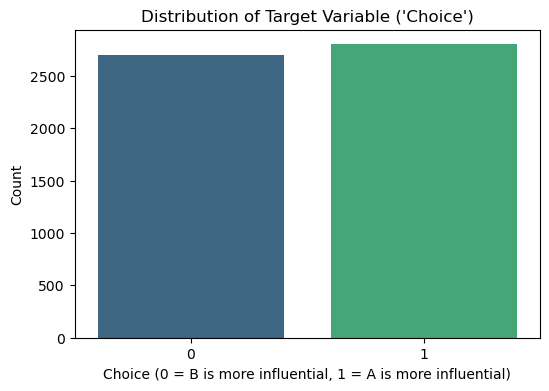

In [53]:
#Distribution of the Target Variable (`Choice`)

plt.figure(figsize=(6, 4))
sns.countplot(x='Choice', data=data, palette='viridis')
plt.title("Distribution of Target Variable ('Choice')")
plt.xlabel("Choice (0 = B is more influential, 1 = A is more influential)")
plt.ylabel("Count")
plt.show()


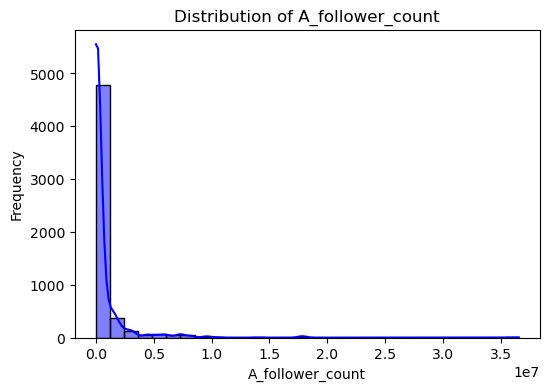

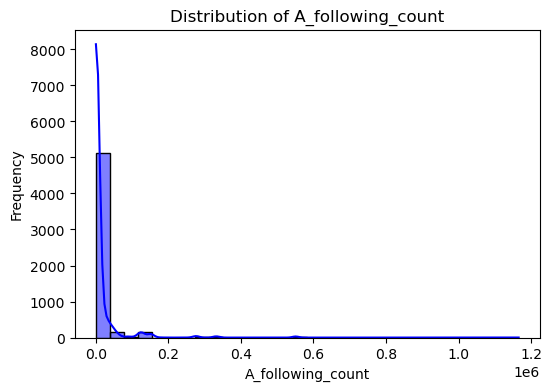

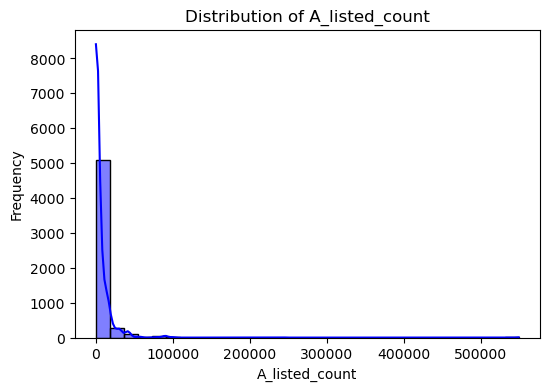

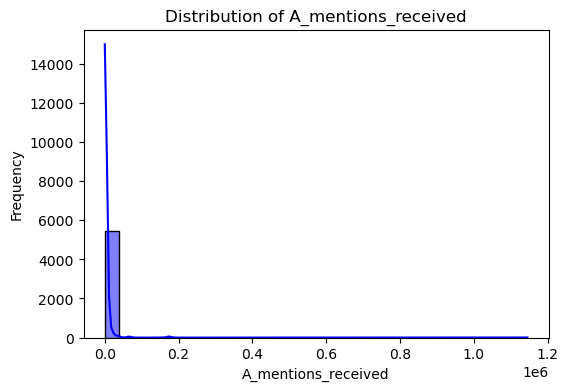

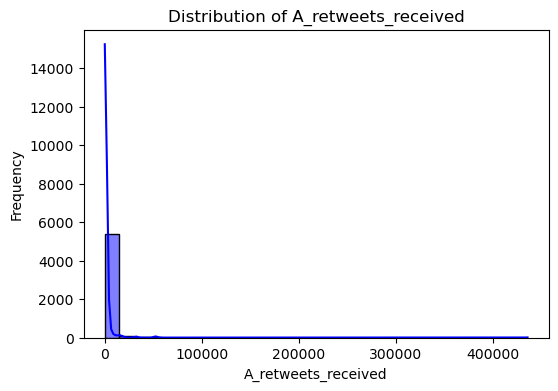

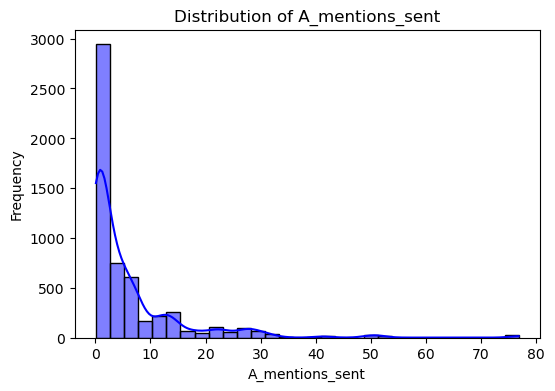

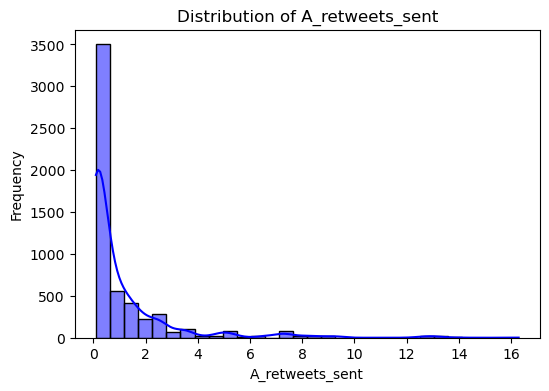

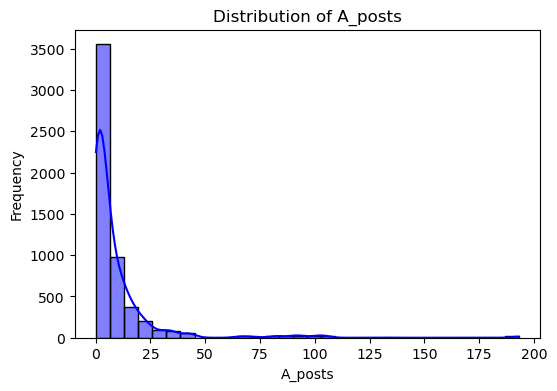

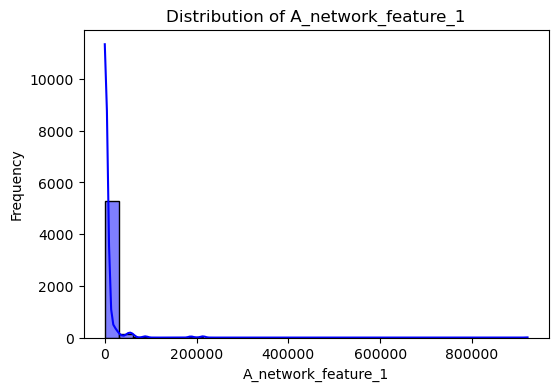

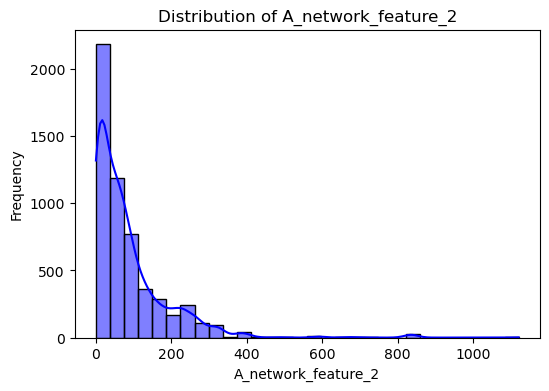

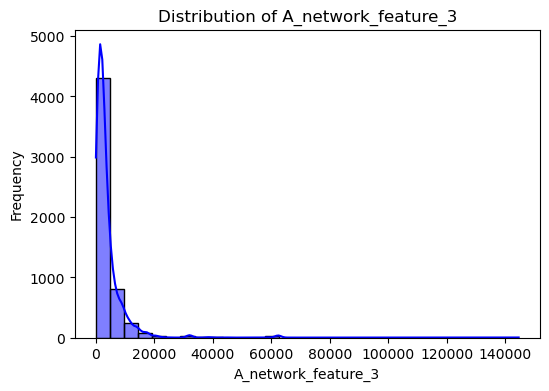

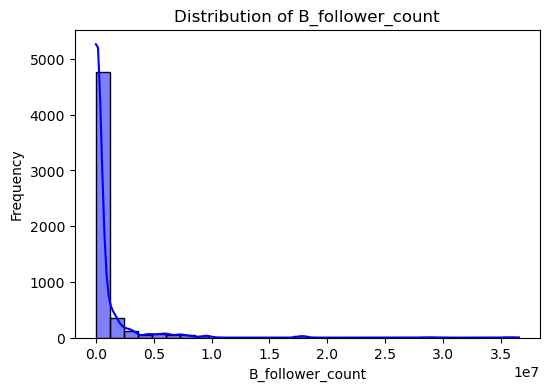

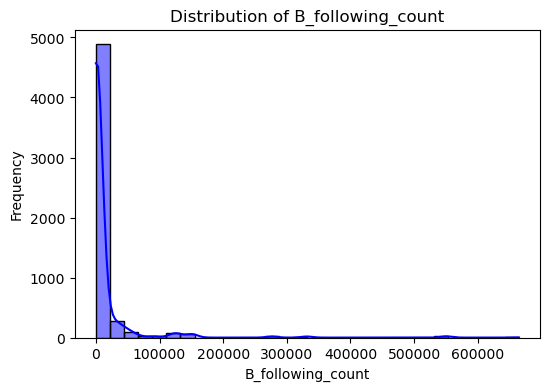

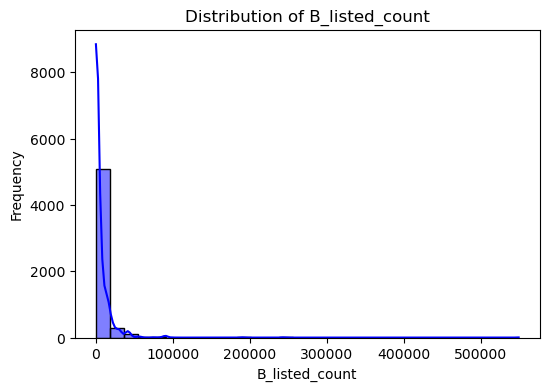

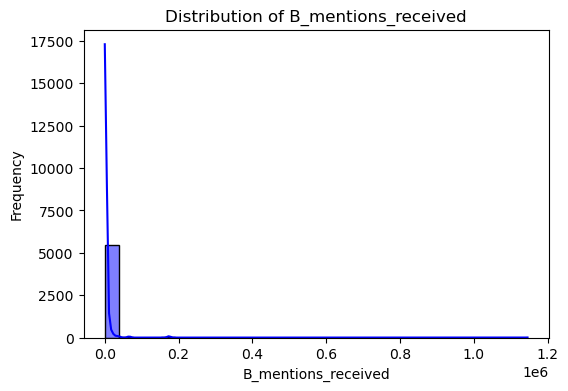

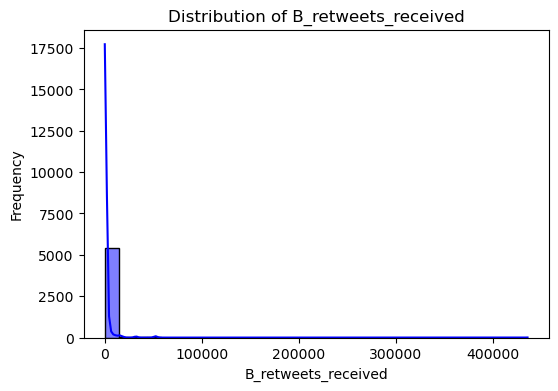

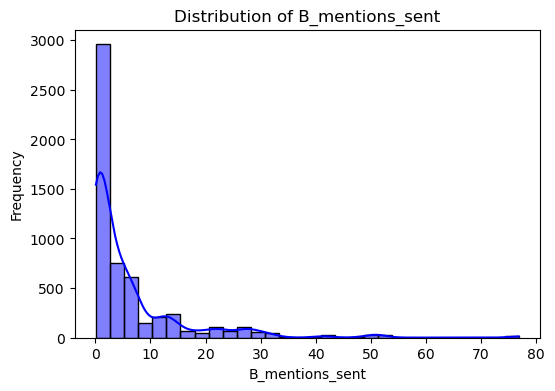

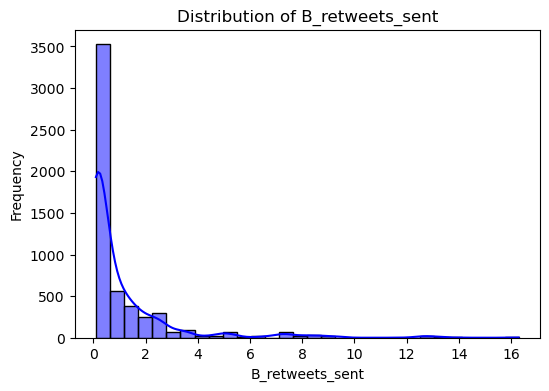

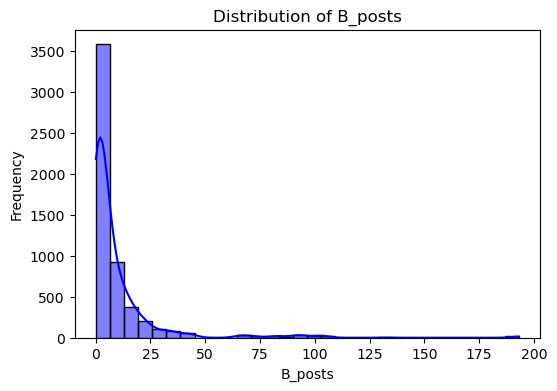

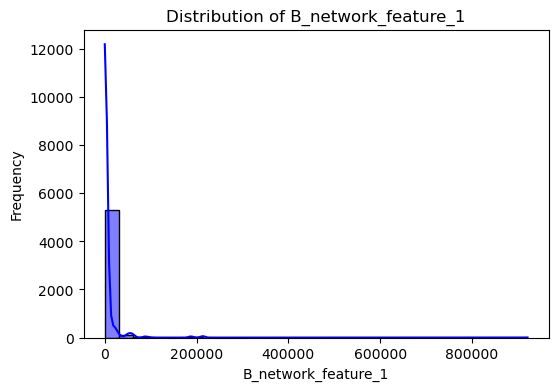

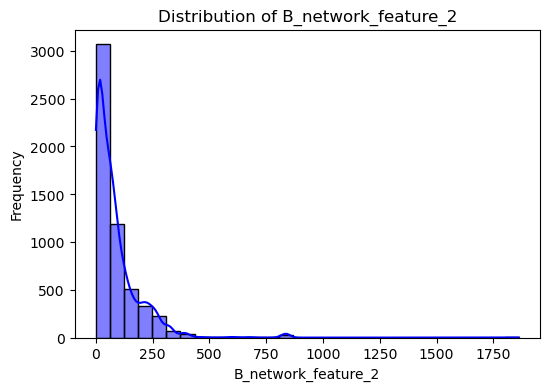

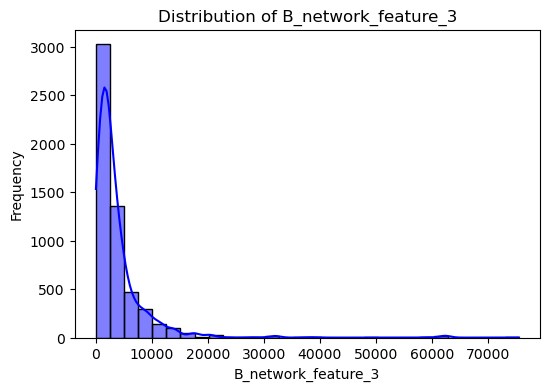

In [54]:

# Step 5: Distribution of Key Numeric Features
numeric_features = data.columns[1:]  # Exclude 'Choice' (target variable)

for feature in numeric_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[feature], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()



### Feature Engineering
Creating features based on the relationship between A & B rather than using the individual metrics of A & B

In [55]:
# Transform variables: Calculate differences (A - B) for each feature
for col in df.columns:
    if col.startswith('A_'):
        feature_name = col[2:]
        df[f'{feature_name}_diff'] = df[col] - df[f'B_{feature_name}']

# Generate additional features with safeguards for division by zero or invalid values
def safe_divide(numerator, denominator):
    return numerator / (denominator + 1e-6)  # Add small value to avoid division by zero

df['retweets_sent_per_follower_diff'] = safe_divide(df['A_retweets_sent'], df['A_follower_count']) - safe_divide(df['B_retweets_sent'], df['B_follower_count'])
df['listed_to_followers_ratio'] = safe_divide(df['A_listed_count'], df['A_follower_count'])
df['mentions_sent_per_following_diff'] = safe_divide(df['A_mentions_sent'], df['A_following_count']) - safe_divide(df['B_mentions_sent'], df['B_following_count'])

df['activity_score_A'] = df['A_posts'] + df['A_retweets_sent'] + df['A_mentions_sent']
df['activity_score_B'] = df['B_posts'] + df['B_retweets_sent'] + df['B_mentions_sent']
df['activity_score_diff'] = df['activity_score_A'] - df['activity_score_B']
df['activity_score_ratio'] = safe_divide(df['activity_score_A'], df['activity_score_B'])
df['retweets_per_follower_ratio'] = safe_divide(df['A_retweets_received'], df['A_follower_count']) / safe_divide(df['B_retweets_received'], df['B_follower_count'])

# Add interaction term
df['activity_score_retweets_interaction'] = df['activity_score_diff'] * df['retweets_sent_per_follower_diff']

# Generate polynomial features for key features
key_features = ['activity_score_diff', 'retweets_sent_per_follower_diff', 'mentions_sent_per_following_diff']
poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df[key_features])
poly_feature_names = poly.get_feature_names_out(key_features)
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)

# Append polynomial features to the dataframe
df = pd.concat([df, poly_df], axis=1)

# Apply K-Means clustering for group identifiers
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(df.drop('Choice', axis=1))


D:\New folder\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Droping the Original columns

In [56]:

# Drop original A and B columns
columns_to_drop = [col for col in df.columns if col.startswith('A_') or col.startswith('B_')]
df = df.drop(columns=columns_to_drop, axis=1)


### Correlation Analysis and Slecting Uncorrelated Features

Removing highly correlated features so that they don't affect the model, while also doing feature selection

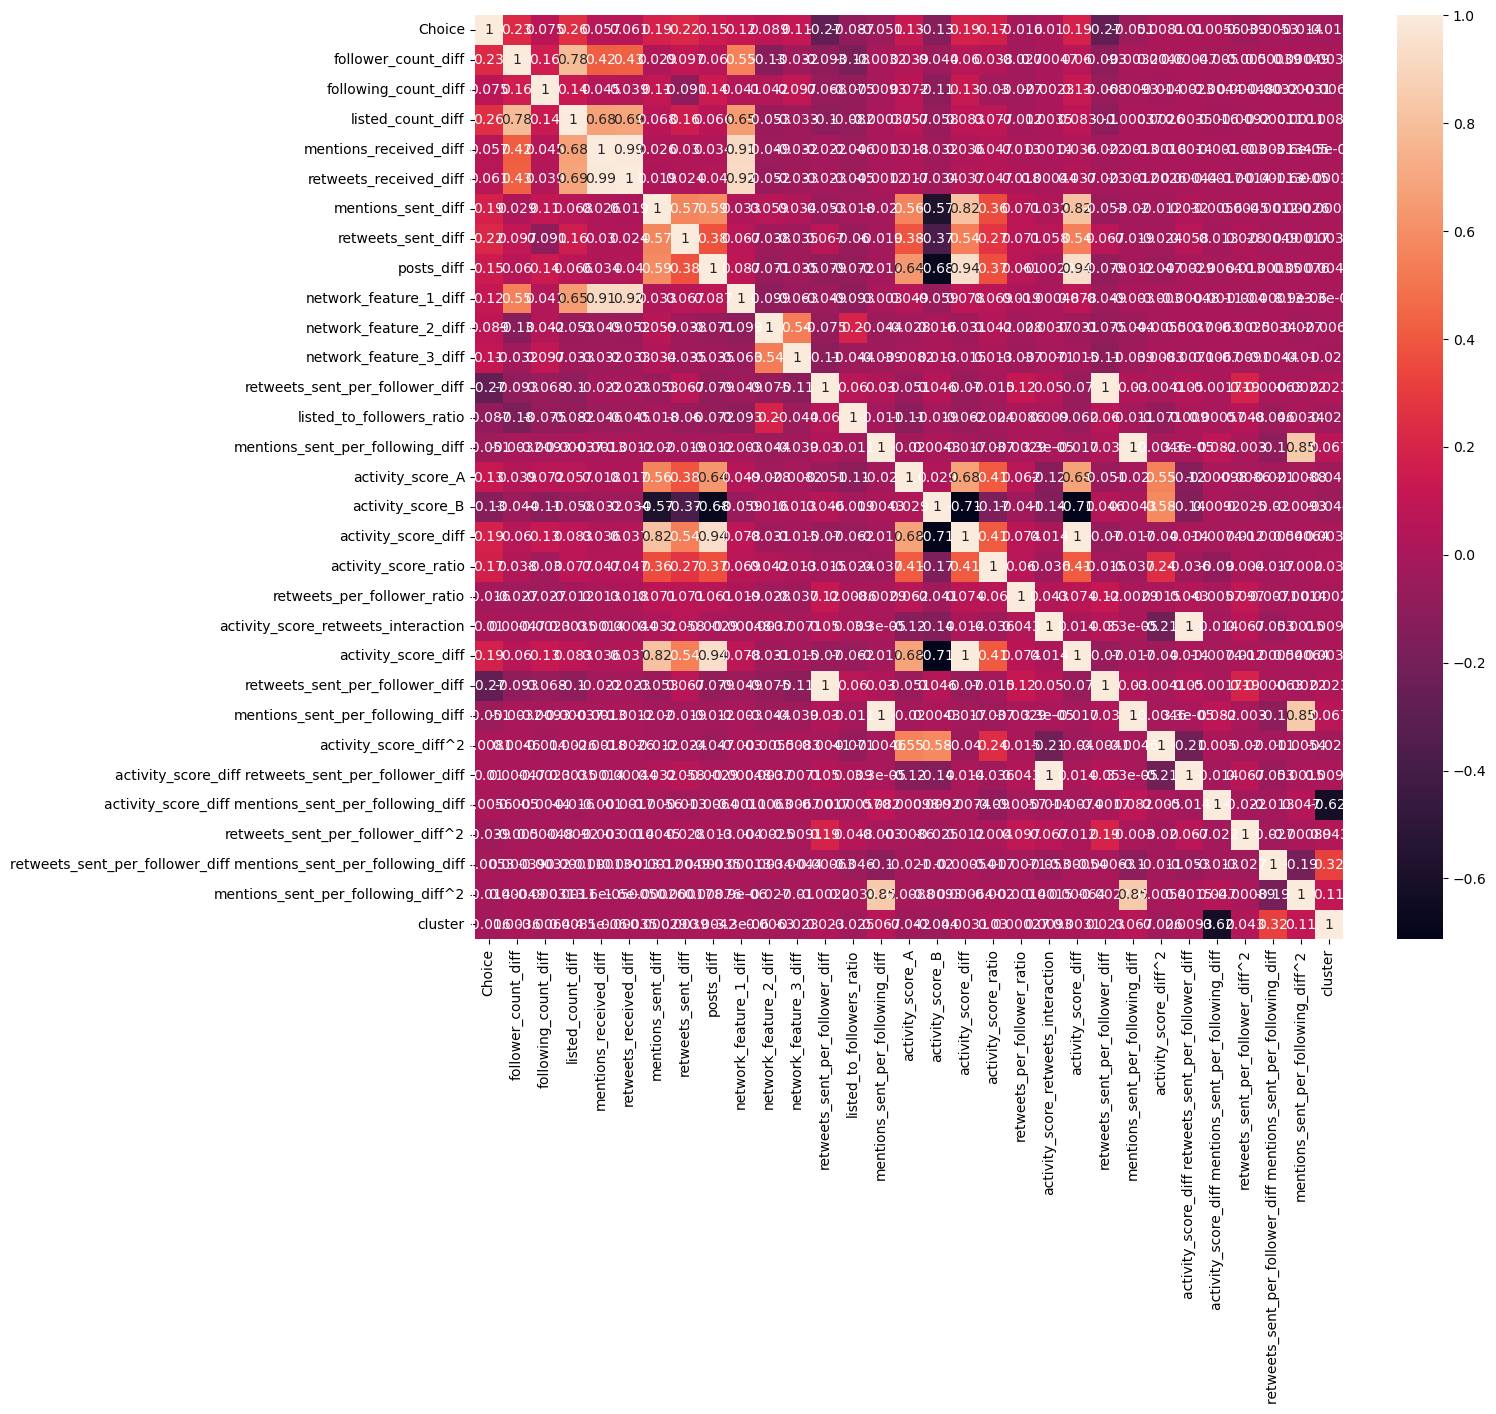

In [57]:
correlations = df.corr()
plt.figure(figsize=(14, 12))  # Adjust the figsize as per your requirement
sns.heatmap(correlations, annot=True)
plt.show()

In [58]:
import pandas as pd
import numpy as np

# Set a threshold for high correlation
threshold = 0.5

# Compute the correlation matrix
correlation_matrix = df.corr().abs()

# Select the upper triangle of the correlation matrix
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation higher than the threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop the first occurring highly correlated column
df_reduced = df.drop(columns=to_drop)
df_reduced['listed_count_diff'] = df['listed_count_diff']
df_reduced=df_reduced.drop(columns=['follower_count_diff'])
df_reduced=df_reduced.drop(columns=['retweets_sent_per_follower_diff^2'])
# Print the columns dropped
print(f"Dropped columns: {to_drop}")

Dropped columns: ['listed_count_diff', 'mentions_received_diff', 'retweets_received_diff', 'retweets_sent_diff', 'posts_diff', 'network_feature_1_diff', 'network_feature_3_diff', 'retweets_sent_per_follower_diff', 'mentions_sent_per_following_diff', 'activity_score_A', 'activity_score_B', 'activity_score_diff', 'activity_score_diff', 'retweets_sent_per_follower_diff', 'mentions_sent_per_following_diff', 'activity_score_diff^2', 'activity_score_diff retweets_sent_per_follower_diff', 'mentions_sent_per_following_diff^2', 'cluster']


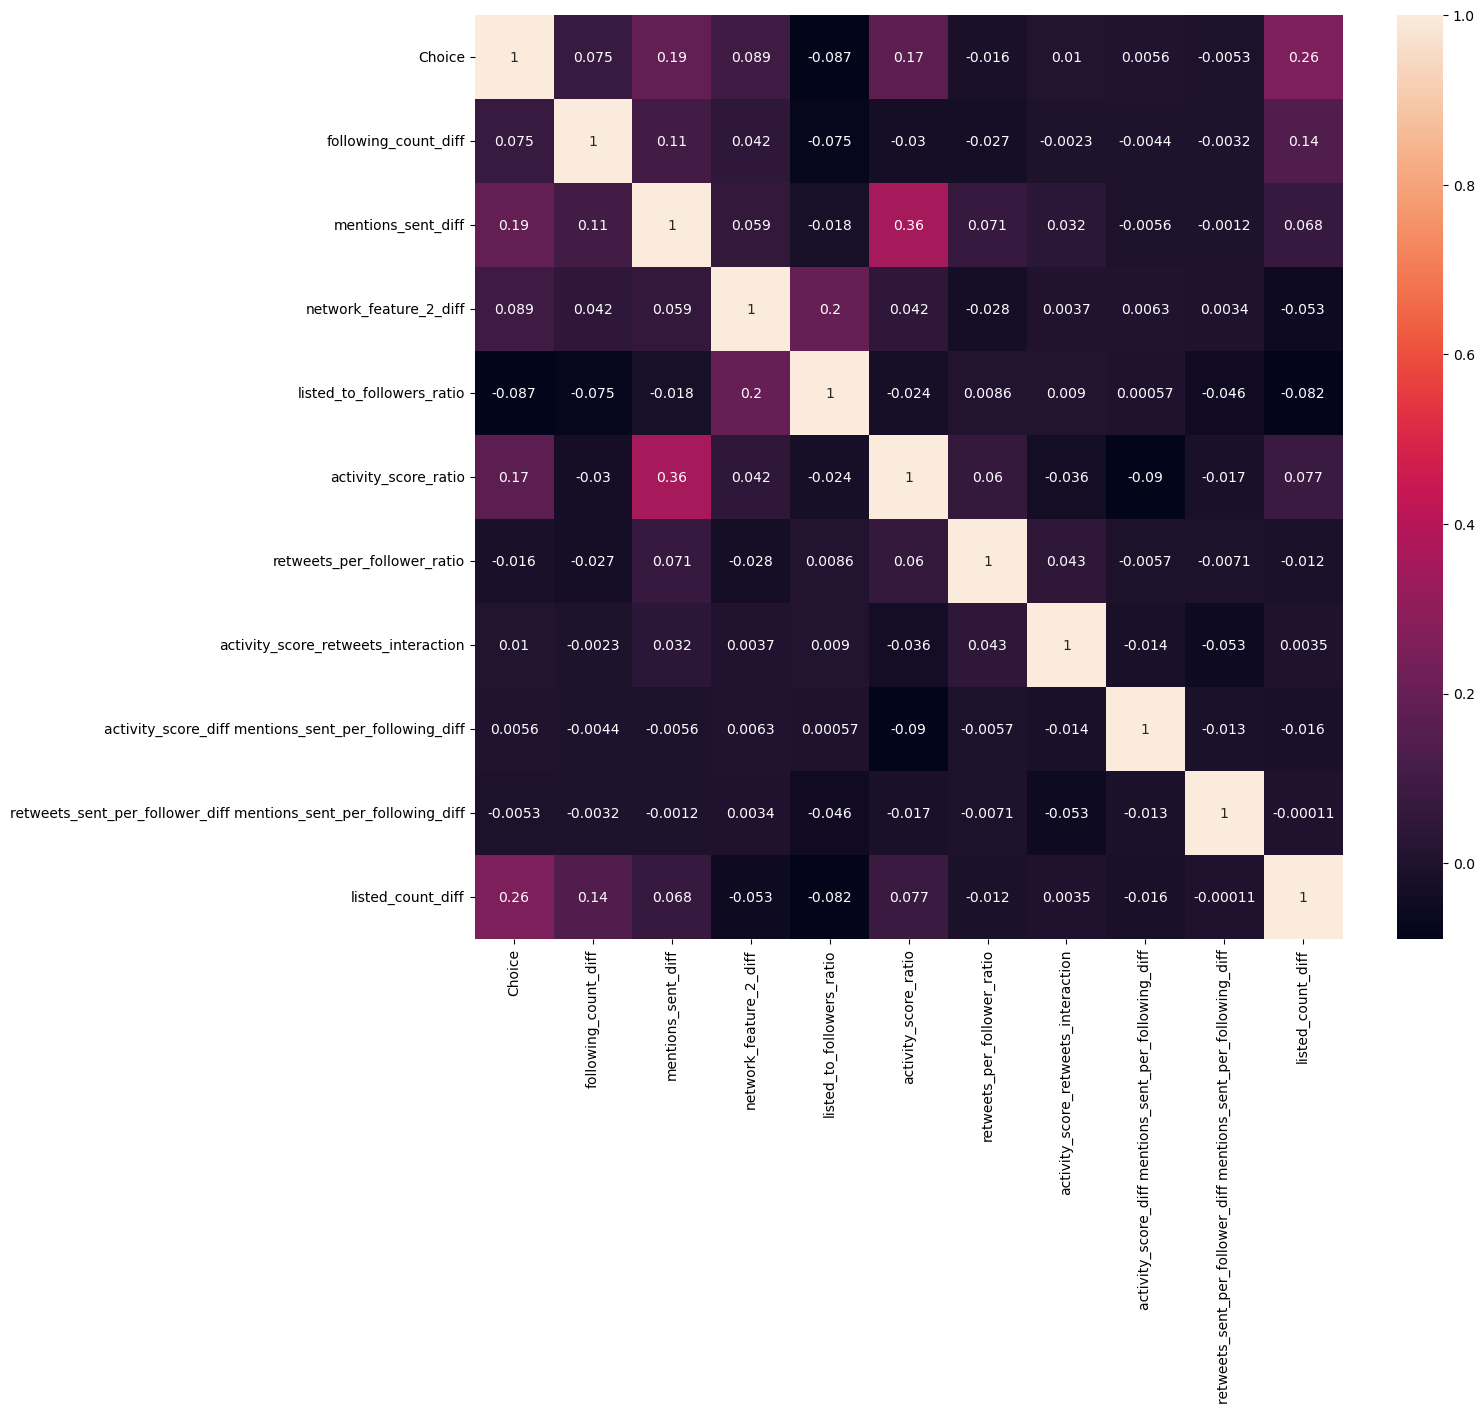

In [59]:
correlations = df_reduced.corr()
plt.figure(figsize=(14, 12))  # Adjust the figsize as per your requirement
sns.heatmap(correlations, annot=True)
plt.show()

### Normalizing data

In [60]:
# Normalize the transformed variables
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(df_reduced.drop('Choice', axis=1))
y = df['Choice']

In [61]:
df_reduced.head()

,Choice,following_count_diff,mentions_sent_diff,network_feature_2_diff,listed_to_followers_ratio,activity_score_ratio,retweets_per_follower_ratio,activity_score_retweets_interaction,activity_score_diff mentions_sent_per_following_diff,retweets_sent_per_follower_diff mentions_sent_per_following_diff,listed_count_diff
0,0,-29506,-8.103828,90.969697,0.013158,0.036273,3.813084,-0.006451,-0.000861,2.481461e-08,-1686
1,0,331,2.481652,-113.587704,0.010560,2.467352,5.245391,0.000265,0.007394,3.843641e-08,-1382
2,0,733,4.758317,58.594502,0.013817,7.301536,13.361498,0.000438,0.026035,1.679552e-07,-105
3,0,-17630,-26.220532,-21.469296,0.100000,0.063791,0.694945,-0.291447,-11.801932,8.788912e-04,-276
4,1,-849,21.117111,78.904293,0.057931,4.424660,1.711674,-0.003202,1.210312,-2.132484e-06,2460


### Split the dataset and build ML Models

In [62]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.25, random_state=42)

# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=28)
rf_model.fit(X_train, y_train)

# Train a Gradient Boosting Classifier
gdb_model = GradientBoostingClassifier(random_state=42)
gdb_model.fit(X_train, y_train)


print("\nRandom Forest")
y_pred_rf = rf_model.predict(X_test)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf)
print("Confusion Matrix:\n", conf_matrix_rf)
print("\nClassification Report:\n", class_report_rf)

print("\nGradient Boosting")
y_pred_gdb = gdb_model.predict(X_test)
conf_matrix_gdb = confusion_matrix(y_test, y_pred_gdb)
class_report_gdb = classification_report(y_test, y_pred_gdb)
print("Confusion Matrix:\n", conf_matrix_gdb)
print("\nClassification Report:\n", class_report_gdb)



Random Forest
Confusion Matrix:
 [[511 168]
 [165 531]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.75       679
           1       0.76      0.76      0.76       696

    accuracy                           0.76      1375
   macro avg       0.76      0.76      0.76      1375
weighted avg       0.76      0.76      0.76      1375


Gradient Boosting
Confusion Matrix:
 [[497 182]
 [161 535]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.73      0.74       679
           1       0.75      0.77      0.76       696

    accuracy                           0.75      1375
   macro avg       0.75      0.75      0.75      1375
weighted avg       0.75      0.75      0.75      1375



### Feature Importance

Feature Importance - RF
                                             Feature  Importance
9                                  listed_count_diff    0.291906
4                               activity_score_ratio    0.136057
6                activity_score_retweets_interaction    0.116098
1                                 mentions_sent_diff    0.110035
2                             network_feature_2_diff    0.088483
0                               following_count_diff    0.085842
3                          listed_to_followers_ratio    0.080137
5                        retweets_per_follower_ratio    0.074595
7  activity_score_diff mentions_sent_per_followin...    0.012634
8  retweets_sent_per_follower_diff mentions_sent_...    0.004213


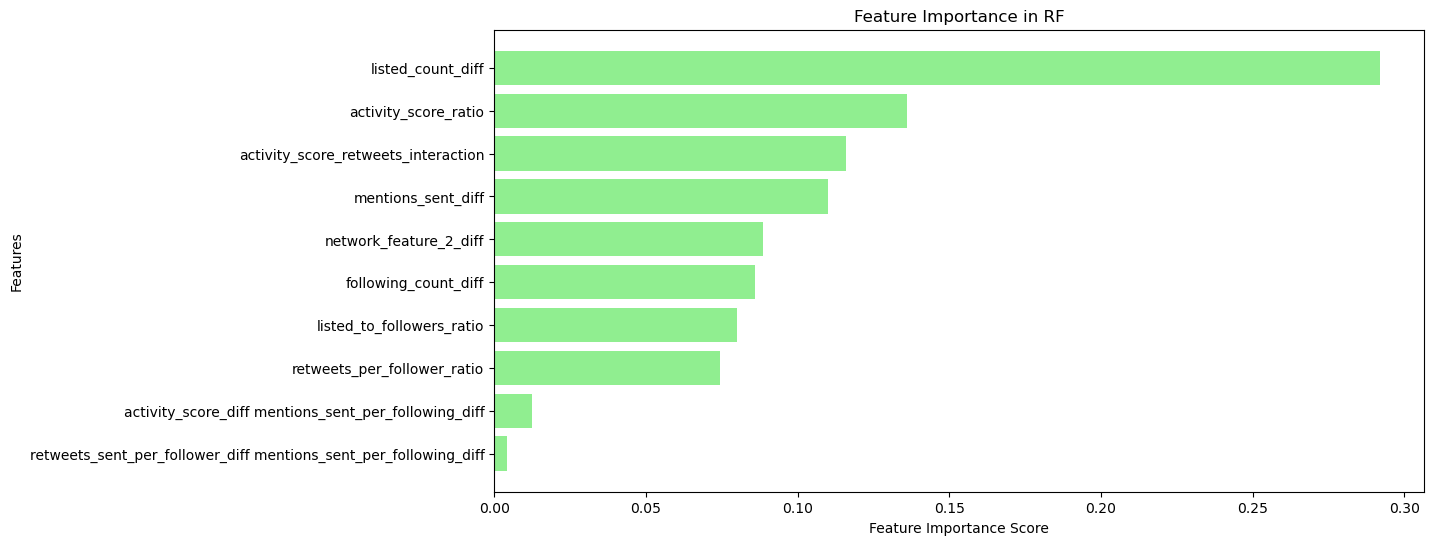

In [63]:
# Ensure X_train is a DataFrame, or extract feature names from the original dataset
feature_names = df_reduced.columns.drop('Choice')  # Replace `target_column` with the actual target variable name

# Get feature importance scores
feature_importances_rf = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df_rf = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances_rf
}).sort_values(by='Importance', ascending=False)

# Print the top features
print("Feature Importance - RF")
print(feature_importance_df_rf)

# Plot the feature importance
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df_rf['Feature'], feature_importance_df_rf['Importance'], color='lightgreen')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in RF")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Based on the classification reports, confusion matrices, and feature importance analysis, both Random Forest (RF) and Gradient Boosting (GB) achieve an accuracy of 76%. However, Random Forest emerges as the preferred model due to its balanced classification performance, lower misclassification rate, and robustness. While Gradient Boosting provides slightly higher precision and recall for Class 0, Random Forest ensures better recall and F1-score for Class 1, resulting in fewer false negatives and more reliable detection across both classes. Additionally, RF is less sensitive to hyperparameter tuning and offers greater interpretability, with key influential features such as listed_count_diff, activity_score_ratio, and mentions_sent_diff playing a significant role in decision-making. The stability and generalizability of RF make it a more practical choice compared to the sensitivity of GB to noise and tuning parameters. While further improvements could be made through feature engineering, hyperparameter tuning, and ensemble methods, Random Forest remains the preferred model for this dataset due to its robustness, balanced classification, and overall effectiveness.

### How Businesses Can Leverage This Information:
1. **Identifying Key Influencers:**
Businesses can analyze features such as listed_count_diff, retweets_per_follower_ratio, and mentions_sent_diff to pinpoint influential users. By identifying users with high engagement and visibility (e.g., those frequently listed in public Twitter lists or receiving many retweets per follower), companies can build a data-driven influencer discovery strategy. This helps in selecting brand ambassadors or partners for marketing initiatives.

2. **Optimizing Targeted Marketing Campaigns:**
Features like activity_score_ratio, network_feature_2_diff, and listed_to_followers_ratio indicate users with strong network reach and engagement levels. Businesses can prioritize these individuals for promotional efforts, such as product seeding, sponsored posts, or collaboration offers, to maximize brand exposure.
3.	**Refining Content Strategies:**
Understanding which metrics contribute to higher engagement—such as activity_score_retweets_interaction and retweets_sent_per_follower_diff^2—allows businesses to tailor their content. For example, if high activity scores correlate with increased audience interaction, companies can focus on content types that encourage shares and discussions.
4.	**Monitoring and Adjusting Influencer Performance:**
By tracking influencer effectiveness using these key features, companies can assess the impact of collaborations. If certain influencers with high following_count_diff or retweets_per_follower_ratio fail to generate meaningful engagement, adjustments can be made by refining influencer selection criteria or modifying campaign strategies.
5.	**Building Strategic Partnerships for Long-Term Engagement:**
Users who consistently perform well on engagement metrics like mentions_sent_diff and activity_score_diff mentions_sent_per_followin are valuable long-term partners. Businesses can use this insight to nurture relationships with high-impact individuals, ensuring sustained marketing effectiveness rather than one-time promotions.



#### Now we will run a logistic regression on the dataset using only the top 5 features found to get the coeffecients and weights for each attribute.

In [64]:
X_normalized

array([[0.34755261, 0.44717812, 0.65902388, ..., 0.82955755, 0.72624757,
        0.51079765],
       [0.36388791, 0.51617575, 0.58835817, ..., 0.82955755, 0.72624757,
        0.5110836 ],
       [0.364108  , 0.53101537, 0.64783965, ..., 0.82955755, 0.72624757,
        0.5122848 ],
       ...,
       [0.3631384 , 0.50118354, 0.66352359, ..., 0.82955755, 0.72624756,
        0.51291598],
       [0.34323514, 0.49095125, 0.54796599, ..., 0.82955755, 0.72624757,
        0.49198948],
       [0.36250879, 0.50185011, 0.68359361, ..., 0.82955755, 0.72624757,
        0.50037532]])

In [65]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select the top 5 most important features by name
top_features = [
    "listed_count_diff",
    "network_feature_2_diff",
    #"activity_score_retweets_interaction",
    "activity_score_ratio",
    "mentions_sent_diff",
    "following_count_diff",
]

# Create a new dataset with only the selected features
X_top = df_reduced[top_features]

# Split the dataset into training and validation sets
X_train_top, X_val_top, y_train_top, y_val_top = train_test_split(X_top, y, test_size=0.2, random_state=42)

# Add a constant term for the logistic regression model
X_train_top_const = sm.add_constant(X_train_top)

# Fit the logistic regression model using statsmodels
logreg_sm = sm.Logit(y_train_top, X_train_top_const)
result = logreg_sm.fit()

# Extract p-values and coefficients
p_values = result.pvalues[1:]  # Remove the constant term
coefficients = result.params[1:]

# Create dictionaries for p-values and coefficients
feature_p_values = dict(zip(top_features, p_values))
feature_coefficients = dict(zip(top_features, coefficients))

# Convert to DataFrame for better visualization
df_p_values = pd.DataFrame.from_dict(feature_p_values, orient='index', columns=['p_values'])
df_coefficients = pd.DataFrame.from_dict(feature_coefficients, orient='index', columns=['coefficients'])

# Combine the p-values and coefficients into a single DataFrame
combined_df = pd.concat([df_p_values, df_coefficients], axis=1)

combined_df

Optimization terminated successfully.
         Current function value: 0.578138
         Iterations 7


,p_values,coefficients
listed_count_diff,9.427037e-91,0.000090
network_feature_2_diff,1.079825e-11,0.001606
activity_score_ratio,1.545643e-11,0.015650
mentions_sent_diff,7.746458e-08,0.015602
following_count_diff,1.665901e-02,0.000001


These coefficients  will be used later in part 2. Also note that all of the features are statistically significant as the p-values of each of the coefficient is < 0.05

### Financial Value Analysis

In [66]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
# Financial Value Calculations
pred = rf_model.predict(X_normalized)

data = pd.read_excel(r'C:\Users\Dell\OneDrive\Desktop\UT Austin Spring\Social Media Analytics\Final Upload\train.xlsx')

# Compute the number of influenced followers
data['followers'] = data['Choice'] * data['A_follower_count'] + (1 - data['Choice']) * data['B_follower_count']
data['model_identified_followers'] = (
    pred * data['Choice'] * data['A_follower_count'] + (1 - pred) * (1 - data['Choice']) * data['B_follower_count']
)

# Compute profit values
perf_once = 10 * 0.0001 * data['followers'].sum()
perf_twice = 10 * 0.00015 * data['followers'].sum()
model_twice = 10 * 0.00015 * data['model_identified_followers'].sum()

# Print updated statistics with clear explanations
print("Financial Value Analysis:\n")
print("1. Net profit using a perfect model (one tweet per influencer):",
      locale.currency(perf_once - 5 * len(data), grouping=True))
print("2. Net profit using a perfect model (two tweets per influencer):",
      locale.currency(perf_twice - 10 * len(data), grouping=True))
print("3. Net profit without any analytics (paying both A and B):",
      locale.currency(perf_once - 10 * len(data), grouping=True))
print("4. Net profit with analytics (paying only identified influencers):",
      locale.currency(model_twice - 10 * len(data), grouping=True))

# Compute profit lift percentages
lift_analytics_vs_no_analytics = (model_twice - perf_once) / (perf_once - 10 * len(data)) * 100
lift_perfect_vs_no_analytics = (perf_twice - perf_once) / (perf_once - 10 * len(data)) * 100

print("5. Lift in expected net profit using analytics vs no analytics:",
      locale.currency(model_twice - 10 * len(data) - (perf_once - 10 * len(data)), grouping=True),
      "(Percent:", round(lift_analytics_vs_no_analytics, 2), "%)")
print("6. Lift in expected net profit using a perfect model vs no analytics:",
      locale.currency(perf_twice - 10 * len(data) - (perf_once - 10 * len(data)), grouping=True),
      "(Percent:", round(lift_perfect_vs_no_analytics, 2), "%)")
print("7. Revenue loss due to model imperfection:",
      locale.currency(perf_twice - model_twice, grouping=True))


Financial Value Analysis:

1. Net profit using a perfect model (one tweet per influencer): $5,349,068.59
2. Net profit using a perfect model (two tweets per influencer): $8,009,852.89
3. Net profit without any analytics (paying both A and B): $5,321,568.59
4. Net profit with analytics (paying only identified influencers): $7,828,048.37
5. Lift in expected net profit using analytics vs no analytics: $2,506,479.78 (Percent: 47.1 %)
6. Lift in expected net profit using a perfect model vs no analytics: $2,688,284.30 (Percent: 50.52 %)
7. Revenue loss due to model imperfection: $181,804.52


# Part II

In [67]:
tweets_data = pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\UT Austin Spring\Social Media Analytics\Final Upload\tweets.csv')

## Extracting Retweets, Mentions, and Building Interaction Network

In [68]:
import re

# Define a function to identify interactions within a tweet
def identify_interactions(content):
    # Look for users mentioned in retweets
    retweet_targets = re.findall(r'RT @(\w+):', content)
    # Look for general mentions (ignoring retweets)
    mention_targets = re.findall(r'(?<!RT )@(\w+)', content)
    return retweet_targets, mention_targets

# Initialize a container to store interaction details
network_edges = []

# Process each tweet row by row
for idx, entry in tweets_data.iterrows():
    user_name = entry[' screen_name'].strip()  # Clean up the screen name
    tweet_body = entry['text']
    
    # Extract retweeted and mentioned users
    retweets, mentions = identify_interactions(tweet_body)
    
    # Capture self-tweets for retweeted usersTweet

    for rt_user in retweets:
        network_edges.append({'Initiator': rt_user, 'Receiver': rt_user, 'Interaction': 'Tweet(Self-Loop)'})
        network_edges.append({'Initiator': user_name, 'Receiver': rt_user, 'Interaction': 'RT'})
    
    # Capture mention interactions, excluding duplicates from retweets
    for mention in mentions:
        if mention not in retweets:
            network_edges.append({'Initiator': user_name, 'Receiver': mention, 'Interaction': 'Mention'})

# Convert the collected edges into a DataFrame
interaction_network = pd.DataFrame(network_edges)

# Drop duplicate interactions to avoid redundancy
interaction_network = interaction_network.drop_duplicates()


In [69]:
interaction_network

,Initiator,Receiver,Interaction
0,jimmichael720,jimmichael720,Tweet(Self-Loop)
1,2Sherryazar1956,jimmichael720,RT
2,ChrisStigall,ChrisStigall,Tweet(Self-Loop)
3,TrueCrimePoli,ChrisStigall,RT
4,ForeignPolicy,ForeignPolicy,Tweet(Self-Loop)
...,...,...,...
6799,rbnkaye99,Cernovich,RT
6801,uncleSlaton,bennyjohnson,RT
6803,DevinAkin,CoryMillsFL,RT
6805,manay44482466,Cernovich,RT


### **Visualizing Social Network Graph and Centrality Metrics**

Below code constructs a directed social network graph from interaction data, calculates key centrality metrics (`degree, betweenness, and closeness`) to identify influential nodes, and visualizes the network using `Plotly`. Nodes are styled based on their connection counts, with hover text providing insights into individual roles within the network. The visualization highlights user interactions, helping identify key influencers and network dynamics effectively.


In [70]:
import networkx as nx
import plotly.graph_objects as go
import pandas as pd

# Create a directed graph from the interaction data
interaction_graph = nx.from_pandas_edgelist(
    interaction_network, 
    source='Initiator', 
    target='Receiver', 
    create_using=nx.DiGraph()
)

# Compute centrality metrics
node_degrees = dict(interaction_graph.degree())
node_betweenness = nx.betweenness_centrality(interaction_graph)
node_closeness = nx.closeness_centrality(interaction_graph)

# Compile centrality metrics into a DataFrame
centrality_metrics = pd.DataFrame({
    'Node_ID': interaction_graph.nodes(),
    'Degree_Centrality': node_degrees.values(),
    'Betweenness_Centrality': node_betweenness.values(),
    'Closeness_Centrality': node_closeness.values()
})

# Define node positions using spring layout
layout_positions = nx.spring_layout(interaction_graph)

# Prepare edges for visualization
edges_x = []
edges_y = []
for edge in interaction_graph.edges():
    start_x, start_y = layout_positions[edge[0]]
    end_x, end_y = layout_positions[edge[1]]
    edges_x.extend([start_x, end_x, None])  # None separates edge segments
    edges_y.extend([start_y, end_y, None])

# Create edge trace for the graph visualization
edges_trace = go.Scatter(
    x=edges_x,
    y=edges_y,
    line=dict(width=0.8, color='#999'),
    hoverinfo='none',
    mode='lines'
)

# Prepare nodes for visualization
nodes_x = []
nodes_y = []
for node in layout_positions:
    node_x, node_y = layout_positions[node]
    nodes_x.append(node_x)
    nodes_y.append(node_y)

# Create node trace
nodes_trace = go.Scatter(
    x=nodes_x,
    y=nodes_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='Viridis',  
        size=15,  
        color=[],  # Placeholder for colors
        colorbar=dict(
            title="Connections",
            thickness=20,
            tickfont=dict(size=12),
        ),
        line=dict(width=2, color='black')  # Added bold borders
    )
)

# Add hover text to nodes
node_colors = []
node_hover_text = []
for node, adjacencies in enumerate(interaction_graph.adjacency()):
    node_colors.append(len(adjacencies[1]))  # Number of connections
    node_hover_text.append(f"Node: {adjacencies[0]} | Connections: {len(adjacencies[1])}")

nodes_trace.marker.color = node_colors
nodes_trace.text = node_hover_text

# Assemble the final graph figure 
network_fig = go.Figure(
    data=[edges_trace, nodes_trace],
    layout=go.Layout(
        title=dict(
            text="Social Network Visualization",
            font=dict(size=22, color="darkblue"),  # title style
            x=0.5  # Centered title
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=20, r=20, t=50),  # margins
        plot_bgcolor="lightgray",  
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
)

# Display the network visualization
network_fig.show()


### Key Observations: Social Network Structure
The visualization represents a directed social network graph, where nodes correspond to users, and edges represent interactions such as mentions, retweets, or replies. The color of each node indicates the number of connections (degree centrality), with lighter colors signifying higher centrality and darker colors representing fewer connections. Nodes closer to the center tend to have more interactions, indicating higher influence, while peripheral nodes have fewer or no connections. The hover text displays additional insights about individual user connections, providing context for their role in the network. The graph reveals densely connected clusters in the center and sparsely connected users on the edges.

### Key Influencers in the Network
Nodes like `dYu7vug97v2Qcqh` (22 connections) and `EmilsionNunesCo2` (15 connections) stand out due to their higher degree centrality, making them potential influencers within the network. Their significant number of connections suggests active engagement, frequent interactions, and the ability to disseminate content effectively. These users could be prioritized for outreach or marketing strategies to amplify reach. Their positions in the graph, being closer to the network's dense core, further support their influence in forming or driving communities.

### Isolated and Low-Activity Users
Nodes such as `SilentAmuse` (0 connections) represent isolated or inactive users in the network. These users do not contribute to or benefit from interactions and may indicate disengaged accounts or accounts not fully integrated into the network. Engaging with such users might require a different strategy, such as personalized outreach or exploring their lack of activity. Identifying isolated users can help refine engagement strategies or focus resources on active participants.




### Normalizing data

In [71]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
metric_scaler = StandardScaler()

# Select and normalize the centrality metrics (exclude the node IDs)
centrality_metrics.iloc[:, 1:] = metric_scaler.fit_transform(centrality_metrics.iloc[:, 1:])

In [72]:
centrality_metrics

,Node_ID,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality
0,jimmichael720,0.135500,2.214107,0.039250
1,2Sherryazar1956,-0.068940,-0.037758,-0.097790
2,ChrisStigall,-0.000794,-0.037758,-0.029270
3,TrueCrimePoli,-0.137087,-0.037758,-0.097790
4,ForeignPolicy,0.953259,-0.037758,0.977677
...,...,...,...,...
2142,rbnkaye99,-0.137087,-0.037758,-0.097790
2143,uncleSlaton,-0.137087,-0.037758,-0.097790
2144,DevinAkin,-0.137087,-0.037758,-0.097790
2145,manay44482466,-0.137087,-0.037758,-0.097790


### **Summarizing User Mentions, Retweets, and Tweets**

In the section below, we summarize user interactions by creating two datasets. One focuses on interactions initiated by users, such as mentions and retweets they’ve sent, while the other captures interactions received, like mentions and retweets directed at them. These summaries help us understand user activity levels and their role within the network.


In [73]:
# Create a pivot table to aggregate data for retweets sent and mentions by the source user
user_interaction_sent = pd.pivot_table(
    interaction_network,
    index='Initiator',
    columns='Interaction',
    aggfunc="count",
    fill_value=0
).reset_index()

# Flatten the multi-level column index and rename the columns for clarity
user_interaction_sent.columns = user_interaction_sent.columns.get_level_values(0)
user_interaction_sent.columns = ['User', "Mention_Sent_Count", 'Retweets_Sent', 'Self_Tweet_Count']

# Create a pivot table to aggregate data for retweets received and mentions by the target user
user_interaction_received = pd.pivot_table(
    interaction_network,
    index='Receiver',
    columns='Interaction',
    aggfunc="count",
    fill_value=0
).reset_index()

# Flatten the multi-level column index and rename the columns for clarity
user_interaction_received.columns = user_interaction_received.columns.get_level_values(0)
user_interaction_received.columns = ['User', "Mention_Received_Count", 'Retweets_Received', 'Self_Tweet_Count']

# Drop the 'Self_Tweet_Count' column as it's not needed for the target user aggregation
user_interaction_received.drop('Self_Tweet_Count', axis=1, inplace=True)


### **Bringing Everything Together**

In the section below, we merge user interaction summaries with metadata like followers and listed counts to create a comprehensive dataset. We also calculate how many posts each user has made and add this information to the final table. This combined dataset gives us a complete view of user activity and sets the stage for identifying influencers.

In [74]:
# Load the tweets dataset
tweets_data = pd.read_csv(r'C:\Users\Dell\OneDrive\Desktop\UT Austin Spring\Social Media Analytics\Final Upload\tweets.csv')

# Merge user interaction data (sent and received) to form a combined user interaction dataset
combined_interaction_data = user_interaction_sent.merge(
    user_interaction_received,
    how='outer',
    left_on='User',
    right_on='User'
).fillna(0)

# Select relevant columns from the tweets dataset and remove duplicates
unique_user_data = tweets_data[[' screen_name', ' listed', ' followers']].drop_duplicates()

# Merge the unique user data with the combined interaction data
final_combined_data = unique_user_data.merge(
    combined_interaction_data,
    how='left',
    left_on=' screen_name',
    right_on='User'
)

# Drop the redundant 'User' column after the merge
final_combined_data.drop('User', axis=1, inplace=True)

# Calculate the number of posts for each user
user_post_counts = tweets_data[' screen_name'].value_counts().reset_index()
user_post_counts.columns = [' screen_name', 'Post_Count']

# Merge the post count data with the final combined dataset
final_combined_data = final_combined_data.merge(
    user_post_counts,
    how='left',
    on=' screen_name'
)


In [75]:
# Initialize a scaler for normalization
data_scaler = StandardScaler()

# Normalize all numeric columns except the user identifier
normalized_user_data = pd.DataFrame(
    data_scaler.fit_transform(final_combined_data.iloc[:, 1:]),
    columns=final_combined_data.iloc[:, 1:].columns
)

# Replace the original numeric columns with the normalized ones
final_combined_data.iloc[:, 1:] = normalized_user_data

# Remove duplicate rows to ensure data consistency
final_combined_data.drop_duplicates(inplace=True)

# Merge normalized user interaction data with centrality metrics
merged_data = centrality_metrics.merge(
    final_combined_data, 
    left_on="Node_ID", 
    right_on=" screen_name", 
    how="inner"
)

# Drop the redundant user identifier column after the merge
merged_data.drop(' screen_name', axis=1, inplace=True)

In [76]:
merged_data

,Node_ID,Degree_Centrality,Betweenness_Centrality,Closeness_Centrality,listed,followers,Mention_Sent_Count,Retweets_Sent,Self_Tweet_Count,Mention_Received_Count,Retweets_Received,Post_Count
0,jimmichael720,0.135500,2.214107,0.039250,-0.078673,-0.026963,-0.423019,0.192450,5.286696,-0.044166,0.772385,1.318809
1,2Sherryazar1956,-0.068940,-0.037758,-0.097790,-0.080091,-0.034167,-0.423019,2.886751,-0.189154,-0.044166,-0.074907,0.236724
2,ChrisStigall,-0.000794,-0.037758,-0.029270,0.339629,0.265824,-0.423019,-2.501851,5.286696,-0.044166,0.348739,-0.304318
3,TrueCrimePoli,-0.137087,-0.037758,-0.097790,-0.080091,-0.044328,-0.423019,0.192450,-0.189154,-0.044166,-0.074907,-0.304318
4,ForeignPolicy,0.953259,-0.037758,0.977677,27.682411,8.893037,-0.423019,-2.501851,5.286696,-0.044166,6.279781,-0.304318
...,...,...,...,...,...,...,...,...,...,...,...,...
1703,rbnkaye99,-0.137087,-0.037758,-0.097790,-0.080091,-0.030133,-0.423019,0.192450,-0.189154,-0.044166,-0.074907,-0.304318
1704,uncleSlaton,-0.137087,-0.037758,-0.097790,-0.080091,-0.048945,-0.423019,0.192450,-0.189154,-0.044166,-0.074907,-0.304318
1705,DevinAkin,-0.137087,-0.037758,-0.097790,0.192160,-0.005944,-0.423019,0.192450,-0.189154,-0.044166,-0.074907,-0.304318
1706,manay44482466,-0.137087,-0.037758,-0.097790,-0.080091,-0.049150,-0.423019,0.192450,-0.189154,-0.044166,-0.074907,-0.304318


In [77]:
feature_coefficients

{'listed_count_diff': 8.957044499254262e-05,
 'network_feature_2_diff': 0.001605756599509295,
 'activity_score_ratio': 0.015650457955637045,
 'mentions_sent_diff': 0.015602396817836461,
 'following_count_diff': 1.4952511189343885e-06}

### Identifying Top 20 Influencers Based on Influence Scores

The activity score is determined by summing up the number of posts, retweets sent, and mentions sent. This calculation is done separately for two entities, A and B, allowing for a comparison between them. The difference in activity scores is then calculated, along with a ratio to provide a relative measure.

Additionally, the number of mentions sent and other related metrics are weighted accordingly. Mentions received are influenced by factors such as betweenness and centrality, which are partially determined by network features. Retweets sent are visible to one's followers, so they are multiplied by the follower count to account for their reach.

In [78]:
# Calculate the Influence Score using existing columns
final_combined_data['Influence_Score'] = (
    final_combined_data[' followers'] * feature_coefficients['activity_score_ratio'] +
    final_combined_data[' listed'] * feature_coefficients['listed_count_diff'] +
    final_combined_data['Mention_Sent_Count'] * feature_coefficients['mentions_sent_diff'] +
    final_combined_data['Mention_Received_Count'] * feature_coefficients['network_feature_2_diff'] +
    final_combined_data['Retweets_Sent'] * feature_coefficients['following_count_diff'] 
)


In [79]:
print("Columns in final_combined_data:", final_combined_data.columns)

Columns in final_combined_data: Index([' screen_name', ' listed', ' followers', 'Mention_Sent_Count',
       'Retweets_Sent', 'Self_Tweet_Count', 'Mention_Received_Count',
       'Retweets_Received', 'Post_Count', 'Influence_Score'],
      dtype='object')


In [80]:
final_combined_data.drop_duplicates(subset=' screen_name', inplace=True)

# Step 3: Sort by Influence Score in descending order and select the top 20
top_influencers = final_combined_data.sort_values(by='Influence_Score', ascending=False).head(20)

In [81]:
top_influencers

,screen_name,listed,followers,Mention_Sent_Count,Retweets_Sent,Self_Tweet_Count,Mention_Received_Count,Retweets_Received,Post_Count,Influence_Score
624,seanhannity,28.192882,41.294116,-0.423019,-2.501851,5.286696,9.689538,27.885721,-0.304318,0.657752
830,dYu7vug97v2Qcqh,-0.078673,-0.042477,9.884610,0.192450,5.286696,-0.044166,1.196031,35.404455,0.153481
1552,ForeignPolicy,27.682411,8.893037,-0.423019,-2.501851,5.286696,-0.044166,6.279781,-0.304318,0.134985
1053,EmilsonNunesCo2,-0.078673,-0.040946,6.939573,-2.501851,-0.189154,-0.044166,-0.074907,12.680691,0.107551
439,Klee34036780,-0.075837,-0.022057,3.994537,0.192450,-0.189154,4.822686,-0.074907,-0.304318,0.069717
141,TPInsidr,0.111335,0.077426,0.067821,0.192450,-0.189154,38.890653,-0.074907,0.236724,0.064729
323,davereaboi,1.095409,1.124790,3.012858,0.192450,-0.189154,-0.044166,-0.074907,-0.304318,0.064639
1194,lepke2112,-0.078673,-0.019434,3.994537,-2.501851,-0.189154,-0.044166,-0.074907,-0.304318,0.061938
1700,lilchiva,-0.064493,-0.036889,3.994537,-2.501851,-0.189154,-0.044166,-0.074907,-0.304318,0.061667
1066,smith77808,-0.080091,-0.049264,3.994537,-2.501851,-0.189154,-0.044166,-0.074907,-0.304318,0.061472
